Predicting The Survival of passengers in RMS Titanic

RMS Titanic
The RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard the ship, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.




Question :- Today the task is to classify whether the person suvived or not


In [3]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB



In [4]:
#Getting the Data
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

#Data Exploration/Analysis
train_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The training-set has 891 examples and 11 features + the target variable (survived). 
2 of the features are floats, 5 are integers and 5 are objects. Below I have listed the features with a short description:

survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation

In [5]:
# describe the training data frame
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Above we can see that 38% out of the training-set survived the Titanic. We can also see that the passenger ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values, like the ‘Age’ feature.

In [6]:
#get the data of first 8 rows
train_df.head(8)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


From the table above, we can note a few things. First of all, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them. Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.



In [7]:
#Print the missing data and percentage
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.



In [8]:
#Print the columns available
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Above you can see the 11 features + the target variable (survived). What features could contribute to a high survival rate ?

To me it would make sense if everything except ‘PassengerId’, ‘Ticket’ and ‘Name’ would be correlated with a high survival rate.


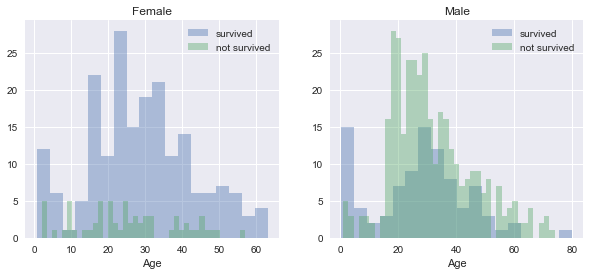

In [9]:
#1. Age and Sex:

survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

Since there seem to be certain ages, which have increased odds of survival and because I want every feature to be roughly on the same scale, I will create age groups later on.


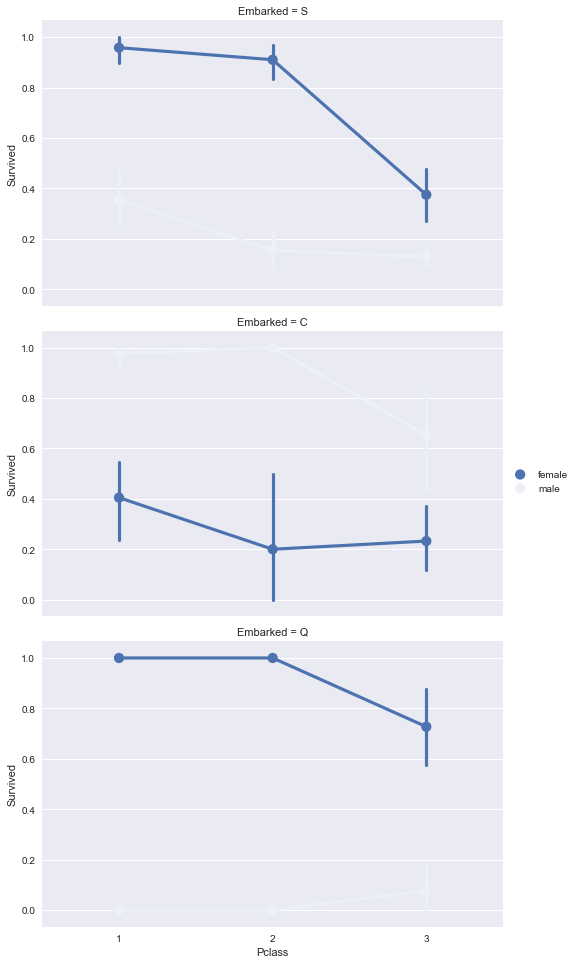

In [10]:
#2. Embarked, Pclass and Sex:

FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender.

Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

Pclass also seems to be correlated with survival. We will generate another plot of it below.


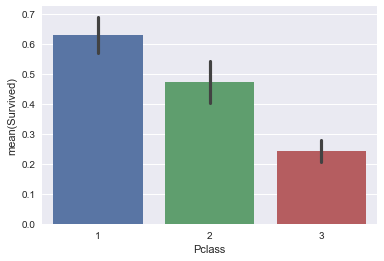

In [12]:
#3. Pclass:

sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.


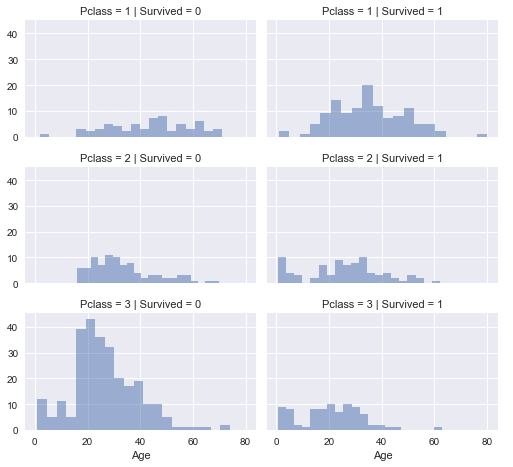

In [13]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The plot above confirms our assumption about pclass 1,
but we can also spot a high probability that a person in pclass 3 will not survive.

4. SibSp and Parch:

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic.
I will create it below and also a feature that sows if someone is not alone.

In [14]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

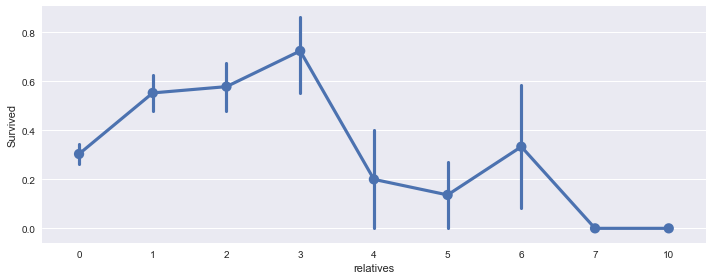

In [15]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

Here we can see that you had a high probabilty of survival with 1 to 3 realitves, 
but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

Data Preprocessing
First, I will drop ‘PassengerId’ from the train set, because it does not contribute to a persons survival probability. I will not drop it from the test set, since it is required there for the submission.



In [16]:
train_df = train_df.drop(['PassengerId'], axis=1)


Age:
Now we can tackle the issue with the age features missing values. I will create an array that contains random numbers, which are computed based on the mean age value in regards 
to the standard deviation and is_null.

In [17]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

Embarked:

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.


In [18]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [19]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [20]:
#Converting Features:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int32
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Cabin        204 non-null object
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int32
dtypes: float64(1), int32(2), int64(5), object(5)
memory usage: 83.6+ KB


Above you can see that ‘Fare’ is a float and we have to deal with 4 categorical features: Name, Sex, Ticket and Embarked. Lets investigate and transfrom one after another.

Fare:
Converting “Fare” from float to int64, using the “astype()” function pandas provides:

In [21]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

Name:
We will use the Name feature to extract the Titles from the Name, so that we can build a new feature out of that.


In [22]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

Sex:
Convert ‘Sex’ feature into numeric.


In [23]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [24]:
#Ticket:

train_df['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [25]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

Embarked:
Convert ‘Embarked’ feature into numeric.

In [26]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null int32
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null int32
Cabin        204 non-null object
Embarked     891 non-null int64
relatives    891 non-null int64
not_alone    891 non-null int32
Title        891 non-null int64
dtypes: int32(3), int64(8), object(1)
memory usage: 73.2+ KB


In [28]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives,not_alone,Title
0,0,3,0,22,1,0,7,NaN,0,1,0,1
1,1,1,1,38,1,0,71,C85,1,1,0,3
2,1,3,1,26,0,0,7,NaN,0,0,1,2
3,1,1,1,35,1,0,53,C123,0,1,0,3
4,0,3,0,35,0,0,8,NaN,0,0,1,1
5,0,3,0,35,0,0,8,NaN,2,0,1,1
6,0,1,0,54,0,0,51,E46,0,0,1,1
7,0,3,0,2,3,1,21,NaN,0,4,0,4
8,1,3,1,27,0,2,11,NaN,0,2,0,3
9,1,2,1,14,1,0,30,NaN,1,1,0,3


Missing Data:
Cabin:
As a reminder, we have to deal with Cabin (687), Embarked (2) and Age (177). First I thought, we have to delete the ‘Cabin’ variable but then I found something interesting. A cabin number looks like ‘C123’ and the letter refers to the deck. Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero. In the picture below you can see the actual decks of the titanic, ranging from A to G.


In [29]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [30]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Deck
0,0,3,0,22,1,0,7,0,1,0,1,8
1,1,1,1,38,1,0,71,1,1,0,3,3
2,1,3,1,26,0,0,7,0,0,1,2,8
3,1,1,1,35,1,0,53,0,1,0,3,3
4,0,3,0,35,0,0,8,0,0,1,1,8
5,0,3,0,35,0,0,8,2,0,1,1,8
6,0,1,0,54,0,0,51,0,0,1,1,5
7,0,3,0,2,3,1,21,0,4,0,4,8
8,1,3,1,27,0,2,11,0,2,0,3,8
9,1,2,1,14,1,0,30,1,1,0,3,8


Creating Categories:
We will now create categories within the following features:

Age:
Now we need to convert the ‘age’ feature. First we will convert it from float into integer. Then we will create the new ‘AgeGroup” variable, by categorizing every age into a group. Note that it is important to place attention on how you form these groups, since you don’t want for example that 80% of your data falls into group 1.


In [31]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed
train_df['Age'].value_counts()

4    163
6    158
5    143
3    136
2    116
1    107
0     68
Name: Age, dtype: int64

Fare:
For the ‘Fare’ feature, we need to do the same as with the ‘Age’ feature. But it isn’t that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn “qcut()” function, that we can use to see, how we can form the categories.

In [32]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Deck
0,0,3,0,2,1,0,7,0,1,0,1,8
1,1,1,1,5,1,0,71,1,1,0,3,3
2,1,3,1,3,0,0,7,0,0,1,2,8
3,1,1,1,5,1,0,53,0,1,0,3,3
4,0,3,0,5,0,0,8,0,0,1,1,8
5,0,3,0,5,0,0,8,2,0,1,1,8
6,0,1,0,6,0,0,51,0,0,1,1,5
7,0,3,0,0,3,1,21,0,4,0,4,8
8,1,3,1,3,0,2,11,0,2,0,3,8
9,1,2,1,1,1,0,30,1,1,0,3,8


In [33]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    

In [34]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Deck
0,0,3,0,2,1,0,0,0,1,0,1,8
1,1,1,1,5,1,0,3,1,1,0,3,3
2,1,3,1,3,0,0,0,0,0,1,2,8
3,1,1,1,5,1,0,3,0,1,0,3,3
4,0,3,0,5,0,0,1,0,0,1,1,8
5,0,3,0,5,0,0,1,2,0,1,1,8
6,0,1,0,6,0,0,3,0,0,1,1,5
7,0,3,0,0,3,1,2,0,4,0,4,8
8,1,3,1,3,0,2,1,0,2,0,3,8
9,1,2,1,1,1,0,2,1,1,0,3,8


Creating new Features
I will add two new features to the dataset, that I compute out of other features.

In [35]:
#Fare per Person

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Deck,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,1,8,0
1,1,1,1,5,1,0,3,1,1,0,3,3,1
2,1,3,1,3,0,0,0,0,0,1,2,8,0
3,1,1,1,5,1,0,3,0,1,0,3,3,1
4,0,3,0,5,0,0,1,0,0,1,1,8,1
5,0,3,0,5,0,0,1,2,0,1,1,8,1
6,0,1,0,6,0,0,3,0,0,1,1,5,3
7,0,3,0,0,3,1,2,0,4,0,4,8,0
8,1,3,1,3,0,2,1,0,2,0,3,8,0
9,1,2,1,1,1,0,2,1,1,0,3,8,1


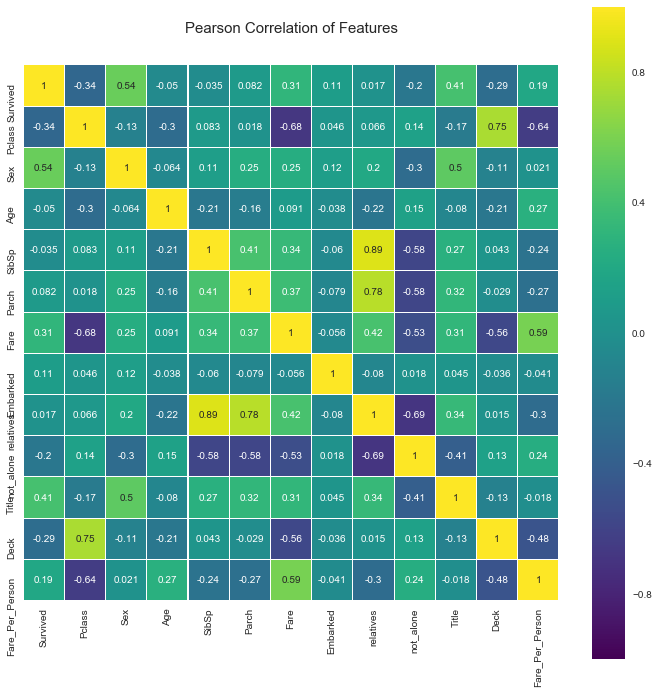

In [38]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Building Machine Learning Models
Now we will train several Machine Learning models and compare their results. Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other. Later on, we will use cross validation.


In [39]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [42]:
#random forest algorithm 
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [43]:
print( acc_random_forest )

92.7


In [44]:
#Logistic Regression:

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

In [45]:
print(acc_log)

81.59


In [47]:
#Gaussian Naive Bayes:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train) 
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(acc_gaussian)

78.23


In [48]:
#Decision Tree

decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train) 
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

print(acc_decision_tree)

92.7


In [ ]:
#Which is the best Model ?

results = pd.DataFrame({
    'Model': [ 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',  
              
              'Decision Tree'],
    'Score': [  acc_log, 
              acc_random_forest, acc_gaussian, 
               acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)


K-Fold Cross Validation:
K-Fold Cross Validation randomly splits the training data into K subsets called folds. 
Let’s image we would split our data into 4 folds (K = 4). Our random forest model would be trained
and evaluated 4 times, using a different fold for evaluation everytime, while it would be trained on the remaining 3 folds.

The image below shows the process, using 4 folds (K = 4).
Every row represents one training + evaluation process. In the first row, the model get’s trained on the first,
second and third subset and evaluated on the fourth. In the second row, the model get’s trained on the second, third and fourth subset and evaluated on the first. K-Fold Cross Validation repeats this process till every fold acted once as an evaluation fold.


The result of our K-Fold Cross Validation example would be an array that contains 4 different scores.
We then need to compute the mean and the standard deviation for these scores.

The code below perform K-Fold Cross Validation on our random forest model, using 10 folds (K = 10). 
Therefore it outputs an array with 10 different scores.

In [53]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.74444444  0.82222222  0.76404494  0.84269663  0.85393258  0.85393258
  0.84269663  0.76404494  0.86516854  0.82954545]
Mean: 0.818272897514
Standard Deviation: 0.0417254301286


This looks much more realistic than before. Our model has a average accuracy of 82% with a standard deviation of 4 %. The standard deviation shows us, how precise the estimates are .

This means in our case that the accuracy of our model can differ + — 4%.

I think the accuracy is still really good and since random forest is an easy to use model, we will try to increase it’s performance even further in the following section.


Let's Try to check why random forest perform really well

Feature Importance
Another great quality of random forest is that they make it very easy to measure the relative importance of each feature. Sklearn measure a features importance by looking at how much the treee nodes, that use that feature, reduce impurity on average (across all trees in the forest). It computes this score automaticall for each feature after training and scales the results so that the sum of all importances is equal to 1. We will acces this below:



In [54]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.218
Sex,0.165
Age,0.154
Pclass,0.088
Deck,0.085
Fare,0.064
relatives,0.059
Embarked,0.052
SibSp,0.040


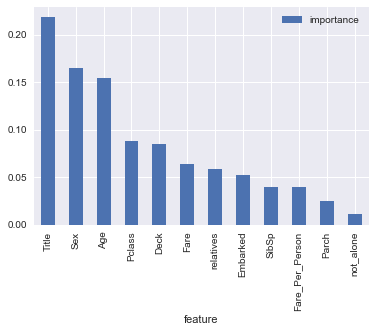

In [55]:
importances.plot.bar()

Conclusion:
not_alone and Parch doesn’t play a significant role in our random forest classifiers prediction process. Because of that I will drop them from the dataset and train the classifier again. We could also remove more or less features, but this would need a more detailed investigation of the features effect on our model. But I think it’s just fine to remove only Alone and Parch.



In [56]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

In [57]:
#Training random forest again:

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.7 %


Our random forest model predicts as good as it did before. A general rule is that, the more features you have, the more likely your model will suffer from overfitting and vice versa. But I think our data looks fine for now and hasn't too much features.

There is also another way to evaluate a random-forest classifier, which is probably much more accurate than the score we used before. What I am talking about is the out-of-bag samples to estimate the generalization accuracy. I will not go into details here about how it works. Just note that out-of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate removes the need for a set aside test set.

In [58]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 81.59 %


Hyperparameter Tuning
Below you can see the code of the hyperparamter tuning for the parameters criterion, min_samples_leaf, min_samples_split and n_estimators.

I put this code into a markdown cell and not into a code cell, because it takes a long time to run it. Directly underneeth it, I put a screenshot of the gridsearch's output.

In [ ]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, Y_train)
clf.bestparams

In [ ]:
#Testing new hyperparameters
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

Now that we have a proper model, we can start evaluating it’s performace in a more accurate way. Previously we only used accuracy and the oob score, which is just another form of accuracy. The problem is just, that it’s more complicated to evaluate a classification model than a regression model. We will talk about this in the following section.



Further Evaluation
Confusion Matrix:

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)


488 , 61
95  , 247

The first row is about the not-survived-predictions: 488 passengers were correctly classified as not survived (called true negatives) and 56 where wrongly classified as not survived (false positives).

The second row is about the survived-predictions: 95 passengers where wrongly classified as survived (false negatives) and 247 where correctly classified as survived (true positives).

A confusion matrix gives you a lot of information about how well your model does, but theres a way to get even more, like computing the classifiers precision.

In [ ]:
#Precision and Recall:

from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))



expected output :->
Precision: 0.801948051948
Recall: 0.722222222222
Our model predicts 81% of the time, a passengers survival correctly (precision). The recall tells us that it predicted the survival of 73 % of the people who actually survived.

F-Score
You can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.



There we have it, a 77 % F-score. The score is not that high, because we have a recall of 73%. But unfortunately the F-score is not perfect, because it favors classifiers that have a similar precision and recall. This is a problem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, sometimes results in an decreasing recall and vice versa (depending on the threshold). This is called the precision/recall tradeoff. We will discuss this in the following section.